# Dropout


### **Prerequisites**
* Regularization

***What will we cover in this notebook?***

* Explaining dropout mathematically and intuitively in neural networks
* Implementation in PyTorch
* Showing the difference between non-dropout and dropout models
* Reviewing some key points
-----

### 1. What is Dropout?


**A brief introduction**

A common problem in machine learning is how to increase our model's performance on unseen data. We want to reduce the test error. To achieve this goal, we apply some regularization strategies. Regularization is defined as "any modification we make to a learning algorithm that is intended to reduce its generalization error but not its training error". We'll focus on dropout which is one of those strategies !

We basically "*drop out*" some neurons in our original network, based on probability. You can assume that we shut down some parts of the neural network during every training example and get different models for each one. After that, we take the average of each model to get prediction in the testing part.



![alt text](images\dropout_network.png)

*Srivastava, Nitish, et al. ”Dropout: a simple way to prevent neural networks from overfitting”, JMLR 2014*

**What is the idea behind 'Dropout'?**

Before diving into math, let's understand what we mean by saying dropout:

Let's assume that e want to have biceps in our arms. So we play tennis, basketball, american football and volleyball in turn for a week. Then we realize that we've done most of them with our dominant hand. We develop large muscle only on that arm and we don't want this.
So in the next week, we follow the schedule below:
* Play tennis with left arm
* Play basketball with right arm
* Play american football with right arm
* Play volleyball with left arm

We change this schedule next week and shuffle arms. After two weeks, we develop biceps on our both arms.



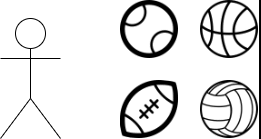

In [32]:
from IPython.display import Image, display
display(Image('images/right_gif.gif'))

The basic idea of the dropout in neural networks is similar to above. Sometimes, one part of the networks has large weights and it ends up dominating all the training while the other part of the network doesn't get trained well. We simply turns off some nodes and say, don't pass through here. With this process, we give chance other weak nodes to train as well as the other powerfull ones.

We apply this process by giving the algorithm a parameter. This parameter is the probability that each node gets dropped at a particular epoch.

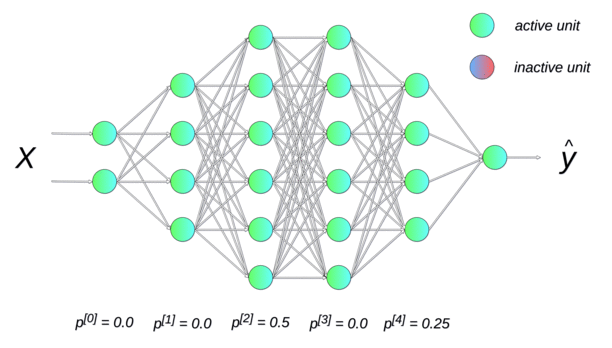

In [30]:
display(Image('images/drop.gif'))

*https://towardsdatascience.com/preventing-deep-neural-network-from-overfitting-953458db800a*

From the math side, dropout can be seen as a process of constructing new inputs by multiplying by noise.

A single layer network:

![math1.pn](images/math1.png)

![math2.png](images/math2.png)

![math3.png](images/math3.png)

![math4.png](images/math4.png)

![math5.png](images/math5.png)

![math6.png](images/math6.png)

![math7.png](images/math7.png)

**Eq. 1** shows loss for a regular network and **Eq. 2** for a dropout network. In Eq. 2, the dropout rate is 𝛿, where 𝛿 ~ Bernoulli(p). This means 𝛿 is equal to 1 with probability p and 0 otherwise.

The backpropagation for network training uses a gradient descent approach. We will first look at the gradient of the dropout network in Eq. 2 and get **Eq. 3**.

We will try to find a relationship between this gradient and the gradient of the regular network. Suppose we make w’ = p*w in Eq. 1.

Then, we get **Eq. 4**.

Taking the derivative of Eq. 4, we find **Eq. 5** and if we find the expectation of the gradient of the Dropout network, we get **Eq. 6**.

Eq. 6, the expectation of the gradient with Dropout, is equal to the gradient of Regularized regular network Eɴ if w’ = p*w.

In the end minimizing the Dropout loss (in Eq. 2) is equivalent to minimizing a regularized network, shown in **Eq. 7**.

### 2. Similarity between dropout and ensembles methods


Bagging (short for bootstrap aggregating) is a technique for reducing generalization error by combining several models. The idea is to train several different models separately, then have all of the models vote on the
output for test examples. This is an example of a general strategy in machine learning called model averaging. 

Techniques employing this strategy are known as ensemble methods.
The reason that model averaging works is that different models will usually
not make all the same errors on the test set.

Dropout can be thought of as a method of making bagging practical for ensembles
of very many large neural networks.

Dropout training is not quite the same as bagging training. 

* In the case of bagging, the models are all independent. 

* In the case of dropout, the models share parameters, with each model inheriting a different subset of parameters from the parent neural network. This parameter sharing makes it possible to represent an exponential number of models with a tractable amount of memory.

* In the case of bagging, each model is trained to convergence on its respective training set. 
* In the case of dropout, typically most models are not explicitly trained at all—usually, the model is large enough that it would be infeasible to sample all possible subnetworks within the lifetime of the universe.

Beyond these differences, dropout follows the bagging algorithm. For
example, the training set encountered by each sub-network is indeed a subset of
the original training set sampled with replacement.

![ensemble_example.PNG](images/ensemble_example.png)

### 3. Implementation in PyTorch on a basic neural network 

We'll do an implementation with MNIST dataset which is a very popular data and contains 77.000 handwritten digits. Every data points has 28x28 grayscale image and a label (the digit) from 0 to 9.
We'll cover non-dropout and dropout models together. Let's do  it!

* Load and prepare the dataset


In [1]:
import torch
from torchvision import datasets, transforms

crop_size = 22

traintransforms = []
traintransforms.append(transforms.CenterCrop(crop_size))
traintransforms.append(transforms.ToTensor())
traintransforms = transforms.Compose(traintransforms)

# GET THE TRAINING DATASET
train_data = datasets.MNIST(root='MNIST-data',                        # where is the data (going to be) stored
                            transform=traintransforms,          # transform the data from a PIL image to a tensor
                            train=True,                               # is this training data?
                            download=True                             # should i download it if it's not already here?
                           )

testtransforms = []
testtransforms.append(transforms.RandomCrop(crop_size))
testtransforms.append(transforms.ToTensor())
testtransforms = transforms.Compose(testtransforms)

# GET THE TEST DATASET
test_data = datasets.MNIST(root='MNIST-data',
                           transform=testtransforms,
                           train=False,
                          )

Extracting MNIST-data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST-data/MNIST/raw


Extracting MNIST-data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST-data/MNIST/raw


Extracting MNIST-data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST-data/MNIST/raw


Extracting MNIST-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST-data/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


* Print some examples:

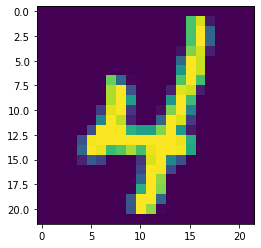

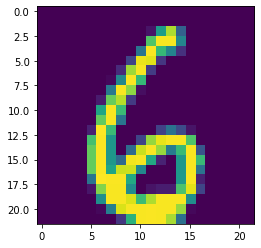

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# PRINT THEIR LENGTHS AND VISUALISE AN EXAMPLE
x = train_data[np.random.randint(0, 300)][0]    # get the first example
plt.imshow(x[0].numpy())
plt.show()
x = test_data[np.random.randint(0, 300)][0]    # get the first example
plt.imshow(x[0].numpy())
plt.show()

* Now, we'll seperate our training dataset into training and validation sets.

In [3]:
# FURTHER SPLIT THE TRAINING INTO TRAINING AND VALIDATION
train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])    # split into 50K training & 10K validation

* Pass datasets to Pytorch dataloader:

In [4]:
batch_size = 128

# MAKE TRAINING DATALOADER
train_loader = torch.utils.data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE VALIDATION DATALOADER
val_loader = torch.utils.data.DataLoader(
    val_data,
    shuffle=True,
    batch_size=batch_size
)

# MAKE TEST DATALOADER
test_loader = torch.utils.data.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)

* It's time to create dropout model !

In [65]:
import torch.nn.functional as F
import torch.nn as nn


class NeuralNetworkClass(torch.nn.Module):
    def __init__(self):
        super().__init__()    # initialise parent module
        self.layer1 = torch.nn.Linear(crop_size*crop_size, 225)
        self.layer2 = torch.nn.Linear(225, 100)
        self.layer3 = torch.nn.Linear(100, 10)
        
    def forward(self, x):
        x = x.view(-1, crop_size*crop_size)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.softmax(x, dim=1)
        return x

def get_n_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    n_params = sum([np.prod(p.size()) for p in model_parameters])
    return n_params




# This is our dropout implementation !
class NeuralNetworkClassDropout(torch.nn.Module):
    def __init__(self):
        super().__init__()    # initialise parent module
        self.layer1 = torch.nn.Linear(crop_size*crop_size, 225)
        self.layer2 = torch.nn.Linear(225, 100)
        self.layer3 = torch.nn.Linear(100, 10)
        self.dropout1 = nn.Dropout(p=0.1)           # first dropout parameter
        self.dropout2 = nn.Dropout(p=0.2)          # second dropout parameter

        
    def forward(self, x):
        x = x.view(-1, crop_size*crop_size)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout1(x)    # apply first dropout after the first layer
        x = self.layer2(x)
        x = F.relu(x)
        x = self.dropout2(x)    # apply second dropout after the second layer
        x = self.layer3(x)
        x = F.softmax(x, dim=1)
        return x

def get_n_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    n_params = sum([np.prod(p.size()) for p in model_parameters])
    return n_params


In [66]:
learning_rate = 0.0005
myNeuralNetwork = NeuralNetworkClass()
print('Number of parameters in non-dropout model:', get_n_params(myNeuralNetwork))
myNeuralNetworkDropout = NeuralNetworkClassDropout()
print('Number of parameters in dropout model:', get_n_params(myNeuralNetworkDropout))

# CREATE OUR OPTIMISER
optimiser_nn = torch.optim.Adam(              # what optimiser should we use?
    myNeuralNetwork.parameters(),          # what should it optimise?
    lr=learning_rate                       # using what learning rate?
)

# CREATE OUR OPTIMISER
optimiser_nnd = torch.optim.Adam(              # what optimiser should we use?
    myNeuralNetworkDropout.parameters(),          # what should it optimise?
    lr=learning_rate                       # using what learning rate?
)

# CREATE OUR CRITERION
criterion = torch.nn.CrossEntropyLoss()             # callable class that compares our predictions to our labels and returns our loss

# SET UP TRAINING VISUALISATION
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()                            # we will use this to show our models performance on a graph


Number of parameters in non-dropout model: 132735
Number of parameters in dropout model: 132735


* Training part:

We assign "p" to represent the probability of a neuron, in the hidden layer, being excluded from the network; this probability value is usually equal to 0.5. We do the same process for the input layer whose probability value is usually lower than 0.5 (e.g. 0.2). Remember, we delete the connections going into, and out of, the neuron when we drop it.

Non-Dropout Model's Loss
Epoch: 1 	Loss: tensor(1.5254, grad_fn=<NllLossBackward>)
Epoch: 2 	Loss: tensor(1.5601, grad_fn=<NllLossBackward>)
Epoch: 3 	Loss: tensor(1.5450, grad_fn=<NllLossBackward>)
Epoch: 4 	Loss: tensor(1.5162, grad_fn=<NllLossBackward>)
Epoch: 5 	Loss: tensor(1.5012, grad_fn=<NllLossBackward>)
Epoch: 6 	Loss: tensor(1.5207, grad_fn=<NllLossBackward>)
Epoch: 7 	Loss: tensor(1.4791, grad_fn=<NllLossBackward>)
Epoch: 8 	Loss: tensor(1.4720, grad_fn=<NllLossBackward>)
Epoch: 9 	Loss: tensor(1.4847, grad_fn=<NllLossBackward>)
Epoch: 10 	Loss: tensor(1.4786, grad_fn=<NllLossBackward>)
Epoch: 11 	Loss: tensor(1.4743, grad_fn=<NllLossBackward>)
Epoch: 12 	Loss: tensor(1.4769, grad_fn=<NllLossBackward>)
Epoch: 13 	Loss: tensor(1.4893, grad_fn=<NllLossBackward>)
Epoch: 14 	Loss: tensor(1.4814, grad_fn=<NllLossBackward>)
Epoch: 15 	Loss: tensor(1.4864, grad_fn=<NllLossBackward>)
Dropout Model's Loss
Epoch: 1 	Loss: tensor(1.6105, grad_fn=<NllLossBackward>)
Epoch: 2 	Loss: tens

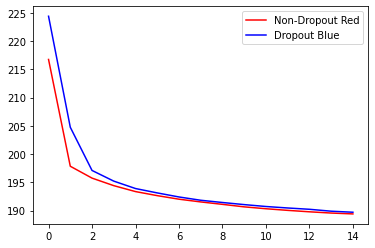

In [67]:
import matplotlib.pyplot as plt

# TRAINING LOOP
def train_nn(model, epochs):
    model.train()                                  # put the model into training mode (more on this later)
    losses_nn = []
    for epoch in range(epochs):
        running_loss_nn = 0.0
        for idx, minibatch in enumerate(train_loader):
            inputs, labels = minibatch
            prediction = model(inputs)             # pass the data forward through the model
            loss = criterion(prediction, labels)   # compute the loss
            optimiser_nn.zero_grad()                  # reset the gradients attribute of each of the model's params to zero
            loss.backward()                        # backward pass to compute and set all of the model param's gradients
            optimiser_nn.step()                       # update the model's parameters
            writer.add_scalar('Loss/Train', loss, epoch*len(train_loader) + idx)    # write loss to a graph
            running_loss_nn += loss.item() * inputs.size(0)
        print('Epoch:', epoch+1, '\tLoss:', loss)
        epoch_loss_nn = running_loss_nn / len(train_loader)
        losses_nn.append(epoch_loss_nn) 
    plt.plot(losses_nn, 'r-', label='Non-Dropout Red')
    #plt.legend()
    #plt.show()

# TRAINING LOOP
def train_nnd(model, epochs):
    model.train()                                  # put the model into training mode (more on this later)
    losses_nnd = []
    for epoch in range(epochs):
        running_loss_nnd = 0.0
        for idx, minibatch in enumerate(train_loader):
            inputs, labels = minibatch
            prediction = model(inputs)             # pass the data forward through the model
            loss = criterion(prediction, labels)   # compute the loss
            optimiser_nnd.zero_grad()                  # reset the gradients attribute of each of the model's params to zero
            loss.backward()                        # backward pass to compute and set all of the model param's gradients
            optimiser_nnd.step()                       # update the model's parameters
            writer.add_scalar('Loss/Train', loss, epoch*len(train_loader) + idx)    # write loss to a graph
            running_loss_nnd += loss.item() * inputs.size(0)
        print('Epoch:', epoch+1, '\tLoss:', loss)    
        epoch_loss_nnd = running_loss_nnd / len(train_loader)
        losses_nnd.append(epoch_loss_nnd) 
    plt.plot(losses_nnd, 'b-', label='Dropout Blue')
    plt.legend()
    plt.show()
            
print("Non-Dropout Model's Loss")
train_nn(myNeuralNetwork, 15)
print("Dropout Model's Loss")           
train_nnd(myNeuralNetworkDropout, 15)

* Evaluate our two models:

In [68]:
def calc_accuracy(model, dataloader):
    num_correct = 0
    num_examples = len(dataloader.dataset)                       # test DATA not test LOADER
    for inputs, labels in dataloader:                  # for all exampls, over all mini-batches in the test dataset
        predictions = model(inputs)
        predictions = torch.max(predictions, axis=1)    # reduce to find max indices along direction which column varies
        predictions = predictions[1]                    # torch.max returns (values, indices)
        num_correct += int(sum(predictions == labels))
    percent_correct = num_correct / num_examples * 100
    return percent_correct

print("Non-Dropout Model's Evaluation:")
print('Train Accuracy:', calc_accuracy(myNeuralNetwork, train_loader))
print('Validation Accuracy:', calc_accuracy(myNeuralNetwork, val_loader))
print('Test Accuracy:', calc_accuracy(myNeuralNetwork, test_loader))

print("\nDropout Model's Evaluation:")
print('Train Accuracy:', calc_accuracy(myNeuralNetworkDropout, train_loader))
print('Validation Accuracy:', calc_accuracy(myNeuralNetworkDropout, val_loader))
print('Test Accuracy:', calc_accuracy(myNeuralNetworkDropout, test_loader))


Non-Dropout Model's Evaluation:
Train Accuracy: 98.378
Validation Accuracy: 97.11999999999999
Test Accuracy: 57.3

Dropout Model's Evaluation:
Train Accuracy: 98.076
Validation Accuracy: 96.82
Test Accuracy: 58.730000000000004


### 4. Visualizing the difference between a non-dropout and dropout implemented nn


![diff.png](images/diff.png)

As we see above, our model's loss curves are converged. They perform very good on training data, but it is poor on test data. So that means, we have a overfitting problem.

We tried a dropout model and saw that test accuracy increased.

* Non-Dropout Model Test Accuracy: 57.3
* Dropout Model Test Accuracy: 58.73

**What to do while testing?**

An output, given from a model trained using the dropout technique, is a bit different: We can take a sample of many dropped-out models and compute the geometric mean of their output neurons by multiplying all the numbers together and taking the product’s square root. However, since this is computationally expensive, we use the original model instead by simply cutting all of the hidden units’ weights in half. This will give us a good approximation of the average for each of the different dropped-out models.

### 5. Summary

* Dropout means turning off some neurons in our network based on probability.
* Dropout helps us to prevent overfitting.
* Dropout follows the bagging algorithm. The training set encountered by each sub-network is indeed a subset of the original training set sampled with replacement. This is the similarity between ensemble models and dropout method.


### 6. What to do next?
* Try to change the dropout parameters and see its effect on training loss and accuracy
* Try to combine dropout with other regularization methods and compare model's performances
* What is the ideal dropout probability rate for different layers? How to choose it? Do some research on the internet, check out the papers and articles.